random choose index for α_2:28
J not move enough
J not move enough
J not move enough
J not move enough
full dataset, iter: 0 i:99,pairs changed:6
iteration number: 1
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
non bound, iter: 1 i:94,pairs changed:0
iteration number: 2
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
full dataset, iter: 2 i:99,pairs changed:0
iteration number: 3
[ 0.65307162 -0.17196128]
-0.925556953596272
2.304363356783872
-1.3670667444213667


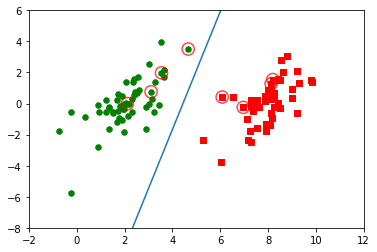

In [110]:
import numpy as np
import matplotlib.pyplot as plt

#一：SMO算法中的辅助函数
#加载数据集
def loadDataSet(filename):
    dataSet = np.loadtxt(filename)
    m,n = dataSet.shape
    data_X = dataSet[:,0:n-1]
    data_Y = dataSet[:,n-1]

    return data_X,data_Y

#随机选取一个数J，为后面内循环选取α_2做辅助（如果α选取不满足条件，就选择这个方法随机选取）
def selectJrand(i,m):   #主要就是根据α_1的索引i,从所有数据集索引中随机选取一个作为α_2的索引
    j = i
    while j==i:
        j = np.int(np.random.uniform(0,m))  #从0~m中随机选取一个数，是进行整数化的
    print("random choose index for α_2:%d"%(j))
    return j    #由于这里返回随机数，所以后面结果 可能导致不同

def clipAlpha(aj,H,L):  #根据我们的SVM算法中的约束条件的分析，我们对获取的aj,进行了截取操作
    if aj > H:
        aj = H
    if aj < L:
        aj = L
    return aj

#二：SMO的支持函数
#首先我们定义一个数据结构（类），来保存所有的重要值
class optStruct:
    def __init__(self,data_X,data_Y,C,toler):   #输入参数分别是数据集、类别标签、常数C用于软间隔、和容错率toler
        self.X = data_X
        self.label = data_Y
        self.C = C
        self.toler = toler  #就是软间隔中的ε，调节最大间隔大小
        self.m = data_X.shape[0]
        self.alphas = np.zeros(self.m)    #存放每个样本点的α值
        self.b = 0  #存放阈值
        self.eCache = np.zeros((self.m,2))  #用于缓存误差，每个样本点对应一个Ei值，第一列为标识符，标志是否为有效值，第二列存放有效值

#计算每个样本点k的Ek值，就是计算误差值=预测值-标签值
def calcEk(oS,k):
    # 根据西瓜书6.24，我们可以知道预测值如何使用α值进行求解
    fxk = np.multiply(oS.alphas,oS.label).T@(oS.X@oS.X[k,:])+oS.b #np.multiply之后还是(m,1),(oS.X@oS.X[k,:])之后是(m,1),通过转置(1,m)@(m,1)-->实数后+b即可得到预测值fx
    #获取误差值Ek
    Ek = fxk - oS.label[k]
    return Ek

#内循环的启发式方法，获取最大差值|Ei-Ej|对应的Ej的索引J
def selectJ(i,oS,Ei):   #注意我们要传入第一个α对应的索引i和误差值Ei,后面会用到
    maxK = -1   #用于保存临时最大索引
    maxDeltaE = 0   #用于保存临时最大差值--->|Ei-Ej|
    Ej = 0  #保存我们需要的Ej误差值

    #重点：这里我们是把SMO最后一步（根据最新阈值b，来更新Ei)提到第一步来进行了，所以这一步是非常重要的
    oS.eCache[i] = [1,Ei]

    #开始获取各个Ek值，比较|Ei-Ej|获取Ej的所有
    #获取所有有效的Ek值对应的索引
    validECacheList = np.where(oS.eCache[:,0]!=0)[0]    #根据误差缓存中第一列非0，获取对应的有效误差值
    if len(validECacheList) > 1:   #如果有效误差缓存长度大于1(因为包括Ei),则正常进行获取j值，否则使用selectJradn方法选取一个随机J值
        for k in validECacheList:
            if k == i:  #相同则不处理
                continue
            #开始计算Ek值，进行对比，获取最大差值
            Ek = calcEk(oS,k)
            deltaE = abs(Ei - Ek)
            if deltaE > maxDeltaE:  #更新Ej及其索引位置
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK,Ej  #返回我们找到的第二个变量α_2的位置
    else:   #没有有效误差缓存，则随机选取一个索引，进行返回
        j = selectJrand(i,oS.m)
        Ej = calcEk(oS,j)
        return j,Ej

#实现更新Ek操作,因为除了最后我们需要更新Ei之外，我们在内循环中计算α_1与α_2时还是需要用到E1与E2，
#因为每次的E1与E2由于上一次循环中更新了α值，所以这一次也是需要更新E1与E2值，所以单独实现一个更新Ek值的方法还是有必要的
def updateEk(oS,k):
    Ek = calcEk(oS,k)
    oS.eCache[k] = [1,Ek]   #第一列1，表示为有效标识

#三：实现内循环函数，相比于外循环，这里包含了主要的更新操作
def innerL(i,oS):   #由外循环提供i值（具体选取要违背kkT<这里实现>,使用交替遍历<外循环中实现>）---提供α_1的索引
    Ei = calcEk(oS,i)   #计算E1值，主要是为了下面KKT条件需要使用到

    #如果下面违背了KKT条件，则正常进行α、Ek、b的更新,重点：后面单独说明下面是否满足违反KKT条件
    if ((oS.label[i]*Ei < -oS.toler) and (oS.alphas[i] < oS.C)) or\
       ((oS.label[i]*Ei > oS.toler) and (oS.alphas[i] > 0)):  #注意：对于硬间隔，我们直接和1对比，对于软间隔，我们要和1 +或- ε对比
        #开始在内循环中，选取差值最大的α_2下标索引
        j,Ej = selectJ(i,oS,Ei)
        #因为后面要修改α_1与α_2的值，但是后面修改阈值b的时候需要用到新旧两个值，所以我们需要在更新α值之前进行保存旧值
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()

        #分析约束条件（是对所有α都适用），一会对我们新的α_2进行截取纠正，注意：α_1是由α_2推出的，所以不需要进行验证了。
        #如果y_1!=y_2异号时：
        if oS.label[i] != oS.label[j]:
            L = max(0,alphaJold-alphaIold)
            H = min(oS.C,oS.C+alphaJold-alphaIold)
        else:   #如果y_1==y_2同号时
            L = max(0,alphaJold+alphaIold-oS.C)
            H = min(oS.C,alphaJold+alphaIold)
        #上面就是将α_j调整到L,H之间
        if L==H:    #如果L==H，之间返回0，跳出这次循环，不进行改变(单值选择，没必要）
            return 0

        #计算η值=k_11+k_22-2k_12
        eta = oS.X[i]@oS.X[i] + oS.X[j]@oS.X[j] - 2.0*oS.X[i]@oS.X[j]  #eta性质可以知道是>=0的，所以我们只需要判断是否为0即可
        if eta <= 0:
            print("eta <= 0")
            return 0

        #当上面所有条件都满足以后，我们开始正式修改α_2值，并更新对应的Ek值
        oS.alphas[j] += oS.label[j]*(Ei-Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j)

        #查看α_2是否有足够的变化量，如果没有足够变化量，我们直接返回，不进行下面更新α_1,注意：因为α_2变化量较小，所以我们没有必要非得把值变回原来的旧值
        if abs(oS.alphas[j] - alphaJold) < 0.00001:
            print("J not move enough")
            return 0

        #开始更新α_1值,和Ek值
        oS.alphas[i] += oS.label[i]*oS.label[j]*(alphaJold-oS.alphas[j])
        updateEk(oS,i)

        #开始更新阈值b,正好使用到了上面更新的Ek值
        b1 = oS.b - Ei - oS.label[i] * (oS.alphas[i] - alphaIold) * oS.X[i] @ oS.X[i] - oS.label[j] * (
                    oS.alphas[j] - alphaJold) * oS.X[i] @ oS.X[j]

        b2 = oS.b - Ej - oS.label[i] * (oS.alphas[i] - alphaIold) * oS.X[i] @ oS.X[j] - oS.label[j] * (
                    oS.alphas[j] - alphaJold) * oS.X[j] @ oS.X[j]

        #根据统计学习方法中阈值b在每一步中都会进行更新，
        #1.当新值alpha_1不在界上时(0<alpha_1<C)，b_new的计算规则为：b_new=b1
        #2.当新值alpha_2不在界上时(0 < alpha_2 < C)，b_new的计算规则为：b_new = b2
        #3.否则当alpha_1和alpha_2都不在界上时，b_new = 1/2(b1+b2)
        if oS.alphas[i] > 0 and oS.alphas[i] < oS.C:
            oS.b = b1
        elif oS.alphas[j] > 0 and oS.alphas[j] < oS.C:
            oS.b = b2
        else:
            oS.b = 1/2*(b1+b2)

        #注意：这里我们应该根据b_new更新一次Ei，但是我们这里没有写，因为我们将这一步提前到了最开始，即selectJ中

        #以上全部更新完毕，开始返回标识
        return 1
    return 0    #没有违背KKT条件

#四：开始外循环，由于我们在内循环中实现了KKT条件的判断，所以这里我们只需要进行交替遍历即可
#交替遍历一种方式是在所有的数据集上进行单遍扫描，另一种是在非边界上（不在边界0或C上的值）进行单遍扫描
# 交替遍历：
# 交替是通过一个外循环来选择第一个alpha值的，并且其选择过程会在两种方式之间交替：
# 一种方式是在所有数据集上进行单遍扫描，
# 另一种方式则是在非边界alpha中实现单遍扫描，所谓非边界alpha指的是那些不等于边界0或C的alpha值。
# 对整个数据集的扫描相当容易，
# 而实现非边界alpha值的扫描时，首先需要建立这些alpha值的列表，然后对这个表进行遍历。
# 同时，该步骤会跳过那些已知不变的alpha值。
def smoP(data_X,data_Y,C,toler,maxIter):
    oS = optStruct(data_X,data_Y,C,toler)
    iter = 0
    entireSet = True    #标志是否应该遍历整个数据集
    alphaPairsChanged = 0   #标志一次循环中α更新的次数
    #开始进行迭代
    #当iter >= maxIter或者((alphaPairsChanged == 0) and not entireSet)退出循环
    #前半个判断条件很好理解，后面的判断条件中，表示上一次循环中，是在整个数据集中遍历，并且没有α值更新过，则退出
    while iter < maxIter and ((alphaPairsChanged > 0) or entireSet):
        alphaPairsChanged = 0
        if entireSet:   #entireSet是true，则在整个数据集上进行遍历
            for i in range(oS.m):
                alphaPairsChanged += innerL(i,oS)   #调用内循环
            print("full dataset, iter: %d i:%d,pairs changed:%d"%(iter,i,alphaPairsChanged))
            iter += 1   #无论是否更新过，我们都计算迭代一次
        else:   #遍历非边界值
            nonBounds = np.where((oS.alphas>0) & (oS.alphas<C))[0]  #获取非边界值中的索引
            for i in nonBounds: #开始遍历
                alphaPairsChanged += innerL(i,oS)
            print("non bound, iter: %d i:%d,pairs changed:%d"%(iter,i,alphaPairsChanged))
            iter += 1   #无论是否更新过，我们都计算迭代一次

        #下面实现交替遍历
        if entireSet:
            entireSet = False
        elif alphaPairsChanged == 0:    #如果是在非边界上，并且α更新过。则entireSet还是False,下一次还是在非边界上进行遍历。可以认为这里是倾向于非边界遍历，因为非边界遍历的样本更符合内循环中的违反KKT条件
            entireSet = True

        print("iteration number: %d"%iter)

    return oS.b,oS.alphas

def calcWs(alphas,data_X,data_Y):
    #根据西瓜书6.37求W
    m,n = data_X.shape
    w = np.zeros(n)
    for i in range(m):
        w += alphas[i]*data_Y[i]*data_X[i].T

    return w

#绘制图像
def plotFigure(weights, b,toler,data_X,data_Y):
    m,n = data_X.shape
    # 进行数据集分类操作
    cls_1x = data_X[np.where(data_Y==1)]
    cls_1y = data_Y[np.where(data_Y==1)]
    cls_2x = data_X[np.where(data_Y!=1)]
    cls_2y = data_Y[np.where(data_Y!=1)]

    plt.scatter(cls_1x[:,0].flatten(), cls_1x[:,1].flatten(), s=30, c='r', marker='s')
    plt.scatter(cls_2x[:,0].flatten(), cls_2x[:,1].flatten(), s=30, c='g')

    # 画出 SVM 分类直线
    xx = np.arange(0, 10, 0.1)
    # 由分类直线 weights[0] * xx + weights[1] * yy1 + b = 0 易得下式
    yy1 = (-weights[0] * xx - b) / weights[1]
    # 由分类直线 weights[0] * xx + weights[1] * yy2 + b + 1 = 0 易得下式
    yy2 = (-weights[0] * xx - b - 1 - toler) / weights[1]
    # 由分类直线 weights[0] * xx + weights[1] * yy3 + b - 1 = 0 易得下式
    yy3 = (-weights[0] * xx - b + 1 + toler) / weights[1]
    plt.plot(xx, yy1.T)
    #plt.plot(xx, yy2.T)
    #plt.plot(xx, yy3.T)

    # 画出支持向量点
    for i in range(m):
        if alphas[i] > 0.0:
            plt.scatter(data_X[i, 0], data_X[i, 1], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='red')

    plt.xlim((-2, 12))
    plt.ylim((-8, 6))
    plt.show()

data_X,data_Y = loadDataSet("testSet.txt")
C = 0.6
toler = 0.001
maxIter = 40

b,alphas = smoP(data_X,data_Y,C,toler,maxIter)

ws = calcWs(alphas,data_X,data_Y)   #含有随机操作，所以有多种可能性结果
print(ws)
test = data_X[0]@ws+b
print(test)
test = data_X[2]@ws+b
print(test)
test = data_X[1]@ws+b
print(test)


plotFigure(ws,b,toler,data_X,data_Y)

In [345]:
import numpy as np
import matplotlib.pyplot as plt

def kernelTrans(X, A, kTup):
    #print(type(A),A.shape)
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0] == 'lin':
        K = X * A.T
    elif kTup[0] == 'rbf':
        for j in range(m):
            deltaRow = X[j,:] - A
            #print("deltaRow",deltaRow, deltaRow.shape)
            K[j] = deltaRow * deltaRow.T
        K = exp(K /(-2*kTup[1]**4))
    elif kTup[0] == 'pkf':
        for j in range(m):
            multiRow = X[j,:]*A.T+1
            K[j] = np.power(multiRow,10)
    else: 
        raise NameError('The Kernel Name cannot be recognition')
    return K

#一：SMO算法中的辅助函数
#加载数据集
def loadDataSet(filename):
    dataSet = np.loadtxt(filename)
    m,n = dataSet.shape
    data_X = dataSet[:,0:n-1]
    data_Y = dataSet[:,n-1]

    return data_X,data_Y

#随机选取一个数J，为后面内循环选取α_2做辅助（如果α选取不满足条件，就选择这个方法随机选取）
def selectJrand(i,m):   #主要就是根据α_1的索引i,从所有数据集索引中随机选取一个作为α_2的索引
    j = i
    while j==i:
        j = np.int(np.random.uniform(0,m))  #从0~m中随机选取一个数，是进行整数化的
    print("random choose index for α_2:%d"%(j))
    return j    #由于这里返回随机数，所以后面结果 可能导致不同
    
def clipAlpha(aj,H,L):  #根据我们的SVM算法中的约束条件的分析，我们对获取的aj,进行了截取操作
    if aj > H:
        aj = H
    if aj < L:
        aj = L
    return aj

#二：SMO的支持函数
#首先我们定义一个数据结构（类），来保存所有的重要值
class optStruct:
    def __init__(self,data_X,data_Y,C,toler, kTup):   #输入参数分别是数据集、类别标签、常数C用于软间隔、和容错率toler；kTup是一个包含核函数信息的
        self.X = data_X
        self.label = data_Y
        self.C = C
        self.toler = toler  #就是软间隔中的ε，调节最大间隔大小
        self.m = data_X.shape[0]
        self.alphas = np.mat(np.zeros((self.m,1)))    #存放每个样本点的α值
        self.b = 0  #存放阈值
        self.eCache = np.mat(np.zeros((self.m,2)))  #用于缓存误差，每个样本点对应一个Ei值，第一列为标识符，标志是否为有效值，第二列存放有效值
        self.K = np.mat(np.zeros((self.m,self.m)))
        #print(self.X)
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)
        
        
#计算每个样本点k的Ek值，就是计算误差值=预测值-标签值
def calcEk(oS,k):
    #fxk = np.multiply(oS.alphas,oS.label).T@oS.K[:,k]+oS.b #np.multiply之后还是(m,1),(oS.X@oS.X[k,:])之后是(m,1),通过转置(1,m)@(m,1)-->实数后+b即可得到预测值fx
    fxk = float(np.multiply(oS.alphas, oS.label).T * oS.K[:, k] + oS.b)
    #获取误差值Ek
    Ek = fxk - oS.label[k]
    return Ek

#内循环的启发式方法，获取最大差值|Ei-Ej|对应的Ej的索引J
def selectJ(i,oS,Ei):   #注意我们要传入第一个α对应的索引i和误差值Ei,后面会用到
    maxK = -1   #用于保存临时最大索引
    maxDeltaE = 0   #用于保存临时最大差值--->|Ei-Ej|
    Ej = 0  #保存我们需要的Ej误差值

    #重点：这里我们是把SMO最后一步（根据最新阈值b，来更新Ei)提到第一步来进行了，所以这一步是非常重要的
    oS.eCache[i] = [1,Ei]

    #开始获取各个Ek值，比较|Ei-Ej|获取Ej的所有
    #获取所有有效的Ek值对应的索引
    validECacheList = np.where(oS.eCache[:,0]!=0)[0]    #根据误差缓存中第一列非0，获取对应的有效误差值
    if len(validECacheList) > 1:   #如果有效误差缓存长度大于1(因为包括Ei),则正常进行获取j值，否则使用selectJradn方法选取一个随机J值
        for k in validECacheList:
            if k == i:  #相同则不处理
                continue
            #开始计算Ek值，进行对比，获取最大差值
            Ek = calcEk(oS,k)
            deltaE = abs(Ei - Ek)
            if deltaE > maxDeltaE:  #更新Ej及其索引位置
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK,Ej  #返回我们找到的第二个变量α_2的位置
    else:   #没有有效误差缓存，则随机选取一个索引，进行返回
        j = selectJrand(i,oS.m)
        Ej = calcEk(oS,j)
        return j,Ej

#实现更新Ek操作,因为除了最后我们需要更新Ei之外，我们在内循环中计算α_1与α_2时还是需要用到E1与E2，
#因为每次的E1与E2由于上一次循环中更新了α值，所以这一次也是需要更新E1与E2值，所以单独实现一个更新Ek值的方法还是有必要的
def updateEk(oS,k):
    Ek = calcEk(oS,k)
    oS.eCache[k] = [1,Ek]   #第一列1，表示为有效标识

#三：实现内循环函数，相比于外循环，这里包含了主要的更新操作
def innerL(i,oS):
    Ei = calcEk(oS,i)   #计算Ei值，主要是为了下面KKT条件需要使用到
    #print(oS.label[i], Ei)
    #如果下面违背了KKT条件，则正常进行α、Ek、b的更新,重点：后面单独说明下面是否满足违反KKT条件
    if ((oS.label[i]*Ei < -oS.toler) and (oS.alphas[i] < oS.C)) or\
       ((oS.label[i]*Ei > oS.toler) and (oS.alphas[i] > 0)):  #注意：对于硬间隔，我们直接和1对比，对于软间隔，我们要和1 +或- ε对比
        #开始在内循环中，选取差值最大的α_2下标索引
        j,Ej = selectJ(i,oS,Ei)
        #因为后面要修改α_1与α_2的值，但是后面修改阈值b的时候需要用到新旧两个值，所以我们需要在更新α值之前进行保存旧值
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()

        #分析约束条件（是对所有α都适用），一会对我们新的α_2进行截取纠正，注意：α_1是由α_2推出的，所以不需要进行验证了。
        #如果y_1!=y_2异号时：
        if oS.label[i] != oS.label[j]:
            L = max(0,alphaJold-alphaIold)
            H = min(oS.C,oS.C+alphaJold-alphaIold)
        else:   #如果y_1==y_2同号时
            L = max(0,alphaJold+alphaIold-oS.C)
            H = min(oS.C,alphaJold+alphaIold)
        #上面就是将α_j调整到L,H之间
        if L==H:    #如果L==H，之间返回0，跳出这次循环，不进行改变(单值选择，没必要）
            return 0

        #计算η值=k_11+k_22-2k_12
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        if eta >= 0:
            print("eta >= 0")#eta应该是小于等于0才对
            return 0

        #当上面所有条件都满足以后，我们开始正式修改α_2值，并更新对应的Ek值
        oS.alphas[j] -= oS.label[j]*(Ei-Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j)

        #查看α_2是否有足够的变化量，如果没有足够变化量，我们直接返回，不进行下面更新α_1,注意：因为α_2变化量较小，所以我们没有必要非得把值变回原来的旧值
        if abs(oS.alphas[j] - alphaJold) < 0.00001:
            print("J not move enough")
            return 0

        #开始更新α_1值,和Ek值
        oS.alphas[i] += oS.label[i]*oS.label[j]*(alphaJold-oS.alphas[j])
        updateEk(oS,i)

        #开始更新阈值b,正好使用到了上面更新的Ek值
        b1 = oS.b - Ei - oS.label[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - \
                            oS.label[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej - oS.label[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j] - \
                            oS.label[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
#         b1 = oS.b - Ei - oS.label[i] * (oS.alphas[i] - alphaIold) * oS.X[i] @ oS.X[i] - oS.label[j] * (
#                     oS.alphas[j] - alphaJold) * oS.X[i] @ oS.X[j]

#         b2 = oS.b - Ej - oS.label[i] * (oS.alphas[i] - alphaIold) * oS.X[i] @ oS.X[j] - oS.label[j] * (
#                     oS.alphas[j] - alphaJold) * oS.X[j] @ oS.X[j]

        #1.当新值alpha_1不在界上时(0<alpha_1<C)，b_new的计算规则为：b_new=b1
        #2.当新值alpha_2不在界上时(0 < alpha_2 < C)，b_new的计算规则为：b_new = b2
        #3.否则当alpha_1和alpha_2都不在界上时，b_new = 1/2(b1+b2)
        if oS.alphas[i] > 0 and oS.alphas[i] < oS.C:
            oS.b = b1
        elif oS.alphas[j] > 0 and oS.alphas[j] < oS.C:
            oS.b = b2
        else:
            oS.b = 1/2*(b1+b2)

        #注意：这里应该根据b_new更新一次Ei，这里没有写，因为我们将这一步提前到了最开始，即selectJ中

        #以上全部更新完毕，开始返回标识
        return 1
    return 0    #没有违背KKT条件

#四：开始外循环，由于我们在内循环中实现了KKT条件的判断，所以这里我们只需要进行交替遍历即可
#交替遍历一种方式是在所有的数据集上进行单遍扫描，另一种是在非边界上（不在边界0或C上的值）进行单遍扫描
# 交替遍历：
# 交替是通过一个外循环来选择第一个alpha值的，并且其选择过程会在两种方式之间交替：
# 一种方式是在所有数据集上进行单遍扫描，
# 另一种方式则是在非边界alpha中实现单遍扫描，所谓非边界alpha指的是那些不等于边界0或C的alpha值。
# 对整个数据集的扫描相当容易，
# 而实现非边界alpha值的扫描时，首先需要建立这些alpha值的列表，然后对这个表进行遍历。
# 同时，该步骤会跳过那些已知不变的alpha值。
def smoP(data_X,data_Y,C,toler,maxIter, kTup=('lin', 0)):
    oS = optStruct(np.mat(data_X),np.mat(data_Y).transpose(), C,toler, kTup)
    iter = 0
    entireSet = True    #标志是否应该遍历整个数据集
    alphaPairsChanged = 0   #标志一次循环中α更新的次数
    #开始进行迭代
    #当iter >= maxIter或者((alphaPairsChanged == 0) and not entireSet)退出循环
    #前半个判断条件很好理解，后面的判断条件中，表示上一次循环中，是在整个数据集中遍历，并且没有α值更新过，则退出
    while iter < maxIter and ((alphaPairsChanged > 0) or entireSet):
        alphaPairsChanged = 0
        if entireSet:   #entireSet是true，则在整个数据集上进行遍历
            for i in range(oS.m):
                alphaPairsChanged += innerL(i,oS)   #调用内循环
            print("full dataset, iter: %d i:%d,pairs changed:%d"%(iter,i,alphaPairsChanged))
            iter += 1   #无论是否更新过，我们都计算迭代一次
        else:   #遍历非边界值
            nonBounds = np.where((oS.alphas>0) & (oS.alphas<C))[0]  #获取非边界值中的索引
            for i in nonBounds: #开始遍历
                alphaPairsChanged += innerL(i,oS)
            print("non bound, iter: %d i:%d,pairs changed:%d"%(iter,i,alphaPairsChanged))
            iter += 1   #无论是否更新过，我们都计算迭代一次

        #交替遍历
        if entireSet:
            entireSet = False
        elif alphaPairsChanged == 0:    #如果是在非边界上，并且α更新过。则entireSet还是False,下一次还是在非边界上进行遍历。可以认为这里是倾向于非边界遍历，因为非边界遍历的样本更符合内循环中的违反KKT条件
            entireSet = True

        print("iteration number: %d"%iter)

    return oS.b,oS.alphas

def calcWs(alphas,data_X,data_Y):
    m,n = data_X.shape
    w = np.zeros(n)
    for i in range(m):
        w += alphas[i]*data_Y[i]*data_X[i].T

    return w

#绘制图像
def plotFigure(data_X,data_Y):
    plt.scatter(data_X[data_Y == 1, 0], data_X[data_Y == 1, 1], linewidth=1.5, marker='o', s=55, edgecolor='blue')
    plt.scatter(data_X[data_Y == -1, 0], data_X[data_Y == -1, 1], linewidth=1.5, marker='x', s=55,edgecolor='red')
    plt.show()

    
def testRbf(filename='testSetRBF.txt', kernel='lin', k1=1.3):
    dataArr, labelArr = loadDataSet(filename)
    #print(dataArr)
    b, alphas = smoP(dataArr, labelArr, 200, 0.01, 10000, (kernel, k1))  # C=200 important
    
    #plotFigure(dataArr,labelArr)
    
    datMat = np.mat(dataArr);
    labelMat = np.mat(labelArr).transpose()
    svInd = nonzero(alphas.A > 0)[0]
    sVs = datMat[svInd]  # get matrix of only support vectors
    labelSV = labelMat[svInd];
    print("there are %d Support Vectors" % shape(sVs)[0])
    m, n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i, :], (kernel, k1))
        predict = kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]): errorCount += 1
    print("the training error rate is: %f" % (float(errorCount) / m))
    dataArr, labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    datMat = np.mat(dataArr);
    labelMat = np.mat(labelArr).transpose()
    #plotFigure(dataArr,labelArr)

    m, n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i, :], (kernel, k1))
        predict = kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]): errorCount += 1
    print("the test error rate is: %f" % (float(errorCount) / m))
    #plot_decision_regions(datMat, labelMat, np.array(y_pred))
    
#     # setup marker generator and color map
    resolution = 0.02
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    X = np.array(datMat)
    y = np.array(labelMat).ravel()
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = datMat[:, 0].min() - 1, datMat[:, 0].max() + 1
    x2_min, x2_max = datMat[:, 1].min() - 1, datMat[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    meshgrid = np.array([xx1.ravel(), xx2.ravel()]).T
    #print(meshgrid.shape[0])
    y_pred = [] 
    for i in range(meshgrid.shape[0]):
        #print(np.mat(meshgrid[i,:]).T.shape)
        kernelEval = kernelTrans(sVs, np.mat(meshgrid[i, :]), (kernel, k1))
        predict = kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b
        y_pred.append(sign(predict))
    #print(y)
    y_pred = np.array(y_pred).reshape(xx1.shape)
    plt.contourf(xx1, xx2, y_pred, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    #print(np.unique(y).shape)
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8, c=cmap(idx),marker=markers[idx], label=cl)
    plt.show()
    return 1-float(errorCount) / m


random choose index for α_2:1
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
full dataset, iter: 0 i:99,pairs changed:12
iteration number: 1
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
non bound, iter: 1 i:24,pairs changed:0
iteration number: 2
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


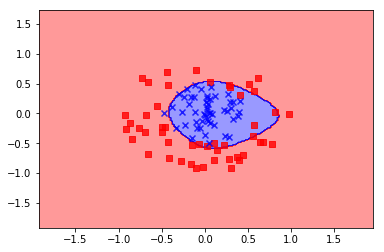

0.88

In [346]:
testRbf(filename='testSetRBF.txt',kernel='pkf')

In [344]:
summ = []
sum = 0
for i in range(10):
    sum += testRbf(filename='testSetRBF.txt',kernel='pkf')
    summ.append(testRbf(filename='testSetRBF.txt',kernel='pkf'))
print(sum/10,summ)

random choose index for α_2:29
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
full dataset, iter: 0 i:99,pairs changed:14
iteration number: 1
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
non bound, iter: 1 i:61,pairs changed:5
iteration number: 2
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
non bound, iter: 2 i:87,pairs changed:3
iteration number: 3
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move 

the test error rate is: 0.050000
random choose index for α_2:34
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
full dataset, iter: 0 i:99,pairs changed:18
iteration number: 1
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
non bound, iter: 1 i:62,pairs changed:1
iteration number: 2
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J 

random choose index for α_2:12
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
full dataset, iter: 0 i:99,pairs changed:26
iteration number: 1
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
non bound, iter: 1 i:54,pairs changed:2
iteration number: 2
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough

J not move enough
J not move enough
non bound, iter: 2 i:87,pairs changed:2
iteration number: 3
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
non bound, iter: 3 i:87,pairs changed:0
iteration number: 4
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enoug

J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
full dataset, iter: 4 i:99,pairs changed:0
iteration number: 5
there are 26 Support Vectors
the training error rate is: 0.010000
the test error rate is: 0.110000
random choose index for α_2:19
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
full dataset, iter: 0 i:99,pairs changed:21
iteration number: 1
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
non b

J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
non bound, iter: 3 i:87,pairs changed:0
iteration number: 4
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
full dataset, iter: 4 i:99,pairs changed:0
iteration number: 5
there are 26 Support Vectors
the training error rate is: 0.010000
the test error rate is: 0.110000
random choose index for α_2:61
J not move enough
J not move enough
J not move enough
J not move enough
J not move enough
J not mov